# Exporting American Movie Box Office Hits 

### Regresssion Model

* Data source: boxofficemojo.com 
* RQ. Can a model predict a movie's international total gross revenue?
* Error metric: adjusted R^2, MAE, RMSE????

1. Load scraped and cleaned movie adapatations dataframe
2. Explore features correlation
3. Explore and handle categorical data
4. Hold 20% of data for final testing
5. Simple linear regression model


In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt


In [9]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet
from sklearn.model_selection import (cross_val_score, train_test_split, KFold, GridSearchCV)
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline


## 1. Load [scraped ](https://github.com/slp22/regression-project/blob/main/adaptation_movies_webscraping.ipynb) and [cleaned](https://github.com/slp22/regression-project/blob/main/adaptation_movies_eda.ipynb) movie adaptations dataframe

In [10]:
movie_df = pd.read_csv('clean_df.csv')
movie_df.drop(columns=['link_stub'], inplace=True)
movie_df.head(2)

,international_total_gross,domestic_total_gross,rank,movie_title,max_theaters,opening_theathers,worldwide_total_gross,domestic_opening,budget,release_date,runtime,distributor,genres,rating
0,1119261396,543638043,6,The Lion King,4802.0,4725.0,1662899439,191770759,260000000,20190711,118.0,Walt Disney Studios Motion Pictures,Adventure Animation Drama Family Musical,PG
1,471115201,534987076,7,The Dark Knight,4366.0,4366.0,1006102277,158411483,185000000,20080716,152.0,Warner Bros.,Action Crime Drama Thriller,PG13


In [ ]:
movie_df.describe()
# domestic_total_gross: min $742, max $543,638,043, transform needed

## 2. Explore features correlation

In [ ]:
# pairplot
sns.pairplot(movie_df, height=3, aspect=1.5);

In [ ]:
# heatmap correlation matrix
sns.heatmap(movie_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

### Correlation Summary

#### Correlation Features-Predictor
*predictor = `international_total_gross`*

* predictor corrolated with (highest to lowest):
    * `domestic_total_gross`
    * `domestic_opening`
    * `budget`
    * `max_theaters`
    * `opening_theathers`
    
Predictor is highly corrolated with `worldwide_total_gross`; has known multicollinearity as:<br/>
`worldwide_total_gross` = `domestic_total_gross` + `international_total_gross`


####  Features-Features > Positive Correlation
* domestic_total_gross:
    * `domestic_opening`
    * `worldwide_total_gross`
    * `budget`
    * `max_theaters`
    * `opening_theathers`

* domestic_opening:<br/>
    * `budget`
    * `max_theaters`
    * `opening_theathers`

* max_theaters:
    * `opening_theathers`
    * `budget`
    * `domestic_opening`


####  Features-Features > Negative Correlation
* rank:
    * `domestic_total_gross`
    * `max_theaters`
    * `opening_theathers`
    * `domestic_opening`
    * `budget`
    


## 3. Explore and handle categorical data

In [46]:
# How many unique genres? What are their frequencies? 
print('Unique genres:', movie_df.genres.nunique())
movie_df['genres'].value_counts()

# 👎 Too many for easy-to-use dummy value

Unique genres: 343


Action Adventure SciFi                             44
Comedy Drama Romance                               24
Comedy                                             23
Action Adventure SciFi Thriller                    20
Drama Romance                                      18
                                                   ..
Drama Mystery Romance                               1
Adventure Comedy Family Fantasy Musical Romance     1
Comedy Drama Fantasy Romance                        1
Action Adventure Family SciFi                       1
Comedy Horror Mystery Thriller                      1
Name: genres, Length: 343, dtype: int64

In [42]:
# How many unique distributors? What are their frequencies? 
print('Unique distributors:', movie_df.distributor.nunique())
movie_df['distributor'].value_counts()

# 👍 Reasonable amount, can group the single counts into other category

Unique distributors: 92


Warner Bros.                           143
Walt Disney Studios Motion Pictures    102
Twentieth Century Fox                  101
Paramount Pictures                     101
Universal Pictures                      94
                                      ... 
Cineplex Odeon Films                     1
FIP                                      1
Amazon Studios                           1
Romar Entertainment                      1
Distrib Films                            1
Name: distributor, Length: 92, dtype: int64

In [43]:
# How many unique MPAA ratings? What are their frequencies? 
print('Unique MPAA ratings:', movie_df.rating.nunique())
movie_df['rating'].value_counts()

# 👍 Easy-to-use number for dummy variables

Unique MPAA ratings: 5


PG13    308
R       223
PG      194
G         8
NC17      1
Name: rating, dtype: int64

In [44]:
# get dummies for distributor 
pd.get_dummies(movie_df['distributor'], drop_first=True).head(2) 

,A24,Alchemy,Alliance Atlantis Vivafilm,Amazon Studios,Anchor Bay Films,Arrow Releasing,Artisan Entertainment,Associated Film Distribution,Atlantic Releasing Corporation,Aviron Pictures,...,Triumph Releasing Corporation,Twentieth Century Fox,United Artists,United Artists Releasing,Universal Pictures,Vertical Entertainment,Vestron Pictures,Walt Disney Studios Motion Pictures,Warner Bros.,Warner Independent Pictures (WIP)
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [45]:
# get dummies for MPAA rating
pd.get_dummies(movie_df['rating'], drop_first=True).head(2) 

,NC17,PG,PG13,R
0,0,1,0,0
1,0,0,1,0


## 4. Split test data set 

In [51]:
X, y = movie_df.drop('price',axis=1), cars['price']

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

NameError: name 'X' is not defined

## 5. Simple linear regression model
FEATURES: `domestic_total_gross`, .... <br/>
TARGET: `international_total_gross`

In [54]:
# split train-test
X_train, X_test, y_tes, y_test = train_test_split(movie_df[['domestic_total_gross']], 
                                                movie_df['international_total_gross'], 
                                                test_size=0.20, 
                                                random_state=42)

In [56]:
# simple linear model (slm)
movie_slm = LinearRegression()
movie_slm.fit(X_train,y_train)

print('train score:', round(movie_slm.score(X_train,y_train), 3))
print('test score:', round(movie_slm.score(X_test,y_test), 3))
print('\n')
print('m_1.coef', movie_slm.coef_ )

# model performs well or not?

train score: 0.772
test score: 0.719


m_1.coef [1.54854313]


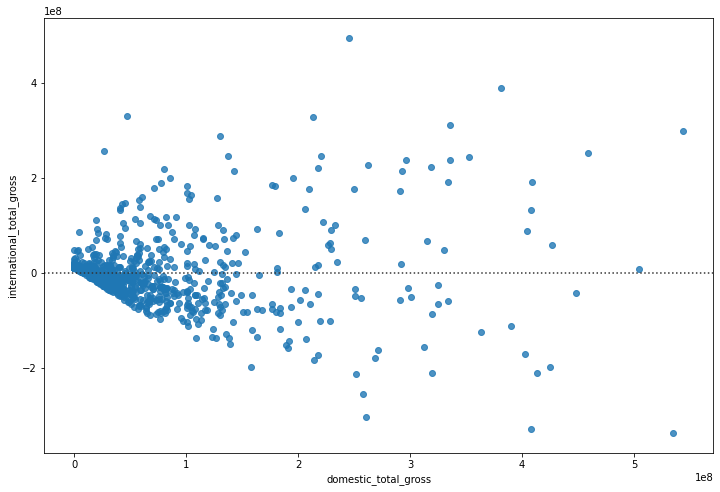

In [57]:
# residual plot 
f, ax = plt.subplots(figsize=(12, 8))
sns.residplot(x='domestic_total_gross', y='international_total_gross', data=movie_df);

# cone shape indicates heteroskedasticity; likely due to the large range of domestic movie revenue

In [ ]:
# ## FEAUTRE
# # 'domestic_total_gross'

# ## TARGET
# # 'international_total_gross'

# # y, X = patsy.dmatrices(' ~ domestic_total_gross + domestic_opening + budget + worldwide_total_gross', data=movie_df, return_type="dataframe")
# # y, X = patsy.dmatrices('international_total_gross ~ domestic_total_gross + domestic_opening + budget',                         data=movie_df, return_type="dataframe")
# # y, X = patsy.dmatrices('international_total_gross ~ domestic_total_gross + domestic_opening',                                  data=movie_df, return_type="dataframe")
# # y, X = patsy.dmatrices('international_total_gross ~ domestic_total_gross + budget',                                            data=movie_df, return_type="dataframe")
# y, X = patsy.dmatrices('international_total_gross ~ domestic_total_gross',                                                     data=movie_df, return_type="dataframe")

# # model
# model = sm.OLS(y, X)

# # fit model
# fit = model.fit()

# # model performance statistics
# fit.summary()



# Modeling

In [ ]:
#set up the 3 models we're choosing from:

#1 LIN REG
# 2 RIDGE
# POLY


#1 LIN REG
lm = LinearRegression()

# ________________________________
#feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

# 2 RIDGE
lm_reg = Ridge(alpha=1)

# ________________________________
#feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

# 3 POLY
lm_poly = LinearRegression()


In [ ]:
# Fit three models and print R^2 score

#1 LIN REG
lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

# 2 RIDGE
lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

# 3 POLY
lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

## #. Cross-validation

In [ ]:
## K-fold, in a less manual way with sk-learn (source: validation_workflow_and_utilities.ipynb)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)

# cross-val-score
cross_val_score(lm, X, y, cv=kf, scoring='r2')

In [ ]:
# build model  (source: regression_lasso_solution.ipynb)
lin_reg_est = LinearRegression()

scores = cross_val_score(lin_reg_est, X_train, y_train, cv=kfold)
print(scores)
print("Linear Reg Mean Score: ", np.mean(scores))

# Build the Model
lin_reg_est.fit(X_train, y_train)

## #. Model tuning 
Take log of some features <br/>
Grid_Search()


## Regularization

In [ ]:
def build_grid_search_est(model, X, y, cv=5, **params): #(source: regression_lasso_solution.ipynb)

    grid_est = GridSearchCV(model, param_grid=params, cv=kfold, 
                            return_train_score=False)
    grid_est.fit(X, y)
    df = pd.DataFrame(grid_est.cv_results_)
    for param in params:
        df[param] = df.params.apply(lambda val: val[param])
#       plt.plot(np.log(df.alpha), df.mean_test_score);
        plt.semilogx(df.alpha, df.mean_test_score)
    return grid_est

In [ ]:
print("Lasso Grid Search") #(source: regression_lasso_solution.ipynb)
lasso_grid_est = build_grid_search_est(Lasso(), X_train, y_train, cv=kfold,
                                       alpha=np.logspace(-4, -1, 30))

In [ ]:
print("Ridge Grid Search") #(source: regression_lasso_solution.ipynb)
ridge_grid_est = build_grid_search_est(Ridge(), X_train, y_train, cv=kfold,
                                       alpha=np.logspace(-4, -1, 10))

In [ ]:
print("Elastic Net Grid Search") #(source: regression_lasso_solution.ipynb)
elastic_net_grid_est = build_grid_search_est(ElasticNet(), X_train, y_train, cv=kfold,
                                             alpha=np.logspace(-4, 0.1, 10))

In [ ]:
print("Lasso Model:")  #(source: regression_lasso_solution.ipynb)
params = {
    "alpha": np.logspace(-4, -.1, 20)
}

grid_est = GridSearchCV(Lasso(), param_grid=params, cv=kfold, 
                        return_train_score=False)
grid_est.fit(X_train, y_train)
df = pd.DataFrame(grid_est.cv_results_)
df["alpha"] = df.params.apply(lambda val: val["alpha"])
plt.plot(np.log(df.alpha), df.mean_test_score);

In [ ]:
print("Ridge Model:") #(source: regression_lasso_solution.ipynb)
params = {
    "alpha": np.logspace(-4, -.1, 20)
}

grid_est = GridSearchCV(Ridge(), param_grid=params, cv=kfold, 
                        return_train_score=False)
grid_est.fit(X_train, y_train)
df = pd.DataFrame(grid_est.cv_results_)
df["alpha"] = df.params.apply(lambda val: val["alpha"])
plt.plot(np.log(df.alpha), df.mean_test_score);

In [ ]:
grid_est.best_estimator_

In [ ]:
params['alpha']

In [ ]:
#(source: regression_lasso_solution.ipynb)


y_pred = lin_reg_est.predict(X_holdout)
print("Linear Regression:", r2_score(y_holdout, y_pred))

y_pred = lasso_grid_est.predict(X_holdout)
print("Lasso Regression:", r2_score(y_holdout, y_pred))

y_pred = ridge_grid_est.predict(X_holdout)
print("Ridge Regression:", r2_score(y_holdout, y_pred))

y_pred = elastic_net_grid_est.predict(X_holdout)
print("ElasticNet Regression:", r2_score(y_holdout, y_pred))

In [ ]:
# evaluate model  (source: regression_lasso_solution.ipynb)

# # Fitted vs. Actual
y_train_pred = lin_reg_est.predict(X_train)

# plt.scatter(y_train, y_train_pred, alpha=0.2)
# plt.plot([0, 400], [0, 400])

# # Fitted vs. Actual 
y_test_pred = lin_reg_est.predict(X_holdout)

# plt.scatter(y_holdout, y_test_pred)
# plt.plot([0, 400], [0, 400])

In [ ]:
# # Plot Residuals vs. predicted  (source: regression_lasso_solution.ipynb)

# lin_reg_residuals = y_train - y_train_pred

# plt.scatter(y_train_pred, lin_reg_residuals)
# plt.plot([0,400], [0, 0])
# plt.title("Residuals vs. Predictions")

## Test linear regression assumptions:
    1. Remove multicollinearity
    2. Transform some features
    3. Look at QQ plots of residuals
    4. Check for independence of errors
    5. Check for heteroskedasticity in residuals!


## #. Features engineering

In [ ]:
# square x5

m_1 = LinearRegression()
m_1.fit(X_train,y_train)

X_train['x5^2'] = X_train['x5']**2 
X_test['x5^2'] = X_test['x5']**2

print('train score with x5^2:', round(m_1.score(X_train,y_train), 3))
print('test score with x5^2:', round(m_1.score(X_test,y_test), 3))
print('\n')
print('m_1.coef  with x5^2', m_1.coef_ )

In [ ]:
# interaction x2 - x3

m_1 = LinearRegression()
m_1.fit(X_train,y_train)

X_train['x2_-_x3'] = (X_train['x2'] - X_train['x3'])
X_test['x2_-_x3'] = (X_test['x2'] - X_test['x3'])


print('train score with x2_-_x3:', round(m_1.score(X_train,y_train), 3))
print('test score with x2_-_x3:', round(m_1.score(X_test,y_test), 3))
print('\n')
print('m_1.coef  with x2_-_x3', m_1.coef_ )

In [ ]:
# x1 * x2

m_3 = LinearRegression()
m_3.fit(X_train,y_train)

X_train['x1_*_x2'] = (X_train['x1']* X_train['x2'])
X_test['x1_*_x2'] = (X_test['x1']* X_test['x2'])


print('train score with x1_*_x2:', round(m_3.score(X_train,y_train), 3))
print('test score with x1_*_x2:', round(m_3.score(X_test,y_test), 3))
print('\n')
print('m_1.coef  with x1_*_x2', m_3.coef_ )

## #. Pick best model 
Fit best model on (train + val), score on test!

In [ ]:
# pd.DataFrame(list(zip(range(10), lasso_grid_est.best_estimator_.coef_)))

## #. Model visualization


In [ ]:
# linear regression plot
f, ax = plt.subplots(figsize=(12, 8))
sns.regplot(x='domestic_total_gross', y='international_total_gross', data=movie_df);


## #. Interpret results
**Interpretability**: Coefficients, what are the top predictors <br/>
**Predictions**: Make a prediction for a new value, does it make sense?